In [191]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from uncertainties import ufloat
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
exec(open('settings.py').read(), globals())

In [192]:
outgrowth = pd.read_csv('../data/outgrowth.csv')

Outgrowth in mm

In [193]:
mean_outgrowth = sp.around(outgrowth[['time', 'length']].groupby('time').agg(['mean', 'sem']) / 1000.0, 2)
mean_outgrowth

length      
       mean   sem
time             
0      0.00  0.00
2      0.06  0.01
3      0.16  0.02
4      0.45  0.04
6      1.28  0.06
8      2.26  0.07

800 micron zone vs 500 micron zone

In [194]:
levan_zone = ufloat(500.0, 0.0)
source_zone = ufloat(800.0, 100.0)
fraction_day0 = levan_zone / source_zone
print fraction_day0

0.62+/-0.08


In [195]:
outgrowth_day8 = float(outgrowth[['time', 'length']].groupby('time').agg('mean').loc[8])
outgrowth_day8_delta = float(outgrowth[['time', 'length']].groupby('time').agg('sem').loc[8])
outgrowth_day8 = ufloat(outgrowth_day8, outgrowth_day8_delta)

In [196]:
fraction_day8 = outgrowth_day8 / (outgrowth_day8 + source_zone)
print fraction_day8

0.738+/-0.025


Finding the avarage trajectory to use for Fig. 1

In [197]:
for i, row in outgrowth.iterrows():
    if row['time'] == 0:
        outgrowth.loc[i, 'chi2'] = 0.0
    else:
        outgrowth.loc[i, 'chi2'] = ((1000 * mean_outgrowth.loc[row['time']]['length', 'mean'] - row['length']) / (1000 * mean_outgrowth.loc[row['time']]['length', 'sem']))**2

In [198]:
chi2 = outgrowth[['ID', 'chi2']].groupby('ID').sum()
chi2

,chi2
ID,
t1,51.930013
t2,35.759247
t3,14.185924
t4,35.708305
t5,32.285244
t6,25.272910
t7,29.312819
t8,37.376990


In [199]:
averageID = chi2.idxmin().iloc[0]
averageID

't3'

Animal t3 has the most average behaviour

In [200]:
outgrowth.query('ID == @averageID')

,ID,time,length,label,chi2
12,t3,0,0,NaN,0.000000
13,t3,2,38,axolotl_sc_outgrowth.tif:t3_2d_0.8x,4.840000
14,t3,3,134,axolotl_sc_outgrowth.tif:t3_3d_0.8x,1.690000
15,t3,4,554,axolotl_sc_outgrowth.tif:t3_4d_0.8x,6.760000
16,t3,6,1285,axolotl_sc_outgrowth.tif:t3_6d_0.8x,0.006944
17,t3,8,2194,axolotl_sc_outgrowth.tif:t3_8d_0.8x,0.888980


Setting the colors:
Iterate the colors, but then make sure the average ID shown in Fig. 1A gets green, which is the 3rd color in the color cycle.

In [201]:
colors = {}
markers = {}
lss = {}
markerlist = ['o', 'v', '^', '<', '>', 's', 'D', '*']
lslist = ['-', '--', '-.', ':', '-', '--', '-.', ':']
colorlist = [1, 2, 3, 4, 5, 6, 7]
for i, ID in enumerate(sp.sort(list(set(outgrowth['ID'].unique()) - set([averageID])))):
    colors[ID] = colorcycle[colorlist[i]]
    markers[ID] = markerlist[i]
    lss[ID] = lslist[i]
colors['t3'] = colorcycle[0]
markers['t3'] = 's'
colors['t4'], colors['t5'] = colors['t5'], colors['t4'] 
colors['t6'], colors['t8'] = colors['t6'], colors['t8'] 

Plotting the outgrowth:

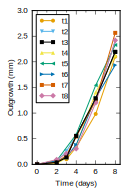

In [202]:
fig, ax = plt.subplots(figsize=(40/25.4,70.0/25.4))
fig.patch.set_alpha(1.0)

for ID, IDdata in outgrowth.groupby('ID'):
    pitem = ax.plot(IDdata['time'], IDdata['length'] / 1000.0, '-', markeredgewidth = 0, color = colors[ID], marker = markers[ID], label = ID)[0]

# plot the average guy last such that you can see him
ax.plot(outgrowth.query('ID == @averageID')['time'], outgrowth.query('ID == @averageID')['length'] / 1000.0, '-', markeredgewidth = 0, color = colors[averageID], marker = 's')
    
ax.set_xlabel('Time (days)')
ax.set_ylabel('Outgrowth (mm)'.decode('utf-8'), labelpad=8)

ax.set_xlim(-0.5, 8.5)
ax.set_xticks([1, 3, 5, 7], minor=True)

plt.legend(loc = 'best')
plt.savefig('../figure_plots/Fig1_outgrowth_trajectories.svg', transparent = True)
plt.show()

Semilog plot of outgrowth + L0

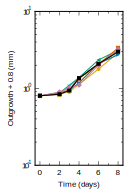

In [218]:
L0 = 0.8
fig, ax = plt.subplots(figsize=(40/25.4,70.0/25.4))
fig.patch.set_alpha(1.0)

for ID, IDdata in outgrowth.groupby('ID'):
    pitem = ax.plot(IDdata['time'], IDdata['length'] / 1000.0 + L0, '-', markeredgewidth = 0, color = colors[ID], marker = markers[ID], label = ID)[0]

# plot the average guy last such that you can see him
ax.plot(outgrowth.query('ID == @averageID')['time'], outgrowth.query('ID == @averageID')['length'] / 1000.0 + L0, '-', markeredgewidth = 0, color = colors[averageID], marker = 's')
    
ax.set_xlabel('Time (days)')
ax.set_ylabel('Outgrowth + 0.8 (mm)'.decode('utf-8'), labelpad=8)

ax.set_xlim(-0.5, 8.5)
ax.set_xticks([1, 3, 5, 7], minor=True)
ax.set_yscale('log')

# plt.legend(loc = 'upper left')
plt.savefig('../figure_plots/Fig3_outgrowth_trajectories_semilog.svg', transparent = True)
plt.show()

### Least square fit with an exponential

In [347]:
import probfit
import iminuit

In [348]:
def growth_model(time, L0, r):
    return L0 * (sp.exp(r * time) - 1.0) 

In [349]:
outgrowth.head()

,ID,time,length,label,chi2
0,t1,0,0,NaN,0.000000
1,t1,2,81,axolotl_sc_outgrowth.tif:t1_2d_0.8x,4.410000
2,t1,3,99,axolotl_sc_outgrowth.tif:t1_3d_0.8x,9.302500
3,t1,4,333,axolotl_sc_outgrowth.tif:t1_4d_0.8x,8.555625
4,t1,6,983,axolotl_sc_outgrowth.tif:t1_6d_0.8x,24.502500


In [373]:
chi2 = probfit.Chi2Regression(growth_model,sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

minuit = iminuit.Minuit(chi2, L0 = 0.8, r = 1.0, error_L0 = 0.1, error_r = 0.1)

minuit.migrad();

FCN = 61.7813563148 
 TOTAL NCALL = 199 
 NCALLS = 199 
 
 
 EDM = 2.08438064812e-08 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,6.702804e-02,7.415289e-03,0.000000e+00,0.000000e+00,,,
2,r,4.500367e-01,1.475923e-02,0.000000e+00,0.000000e+00,,,


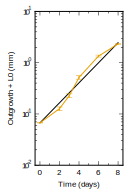

In [367]:
L0 = minuit.values['L0']
r = minuit.values['r']
fig, ax = plt.subplots(figsize=(40/25.4,70.0/25.4))
fig.patch.set_alpha(1.0)

# for ID, IDdata in outgrowth.groupby('ID'):
#     pitem = ax.plot(IDdata['time'], IDdata['length'] / 1000.0 + L0, '-', markeredgewidth = 0, color = colors[ID], marker = markers[ID], label = ID)[0]

ax.plot(time, growth_model(time, L0, r) + L0)
ax.errorbar(sp.array(mean_outgrowth.index),
                                sp.array(mean_outgrowth['length', 'mean'] + L0),
                                sp.array(mean_outgrowth['length', 'sem']))

ax.set_xlabel('Time (days)')
ax.set_ylabel('Outgrowth + L0 (mm)'.decode('utf-8'), labelpad=8)

ax.set_xlim(-0.5, 8.5)
ax.set_xticks([1, 3, 5, 7], minor=True)
ax.set_yscale('log')

plt.show()

### Least square fit with an exponential

but this time time-depndent rate switch

In [353]:
def growth_model2(time, L0, r1, r2, tswitch):
    if tswitch <= 0:
        return L0 * (sp.exp(r2 * time) - 1.0) 
    else:
        if time <= tswitch:
            return L0 * (sp.exp(r1 * time) - 1.0) 
        else:
            L1 = L0 * (sp.exp(r1 * tswitch) - 1.0) + L0
            return L1 * (sp.exp(r2 * (time - tswitch)) - 1.0)  + L1 - L0

In [354]:
chi2_2 = probfit.Chi2Regression(growth_model2,
                                sp.array(mean_outgrowth.index)[1:],
                                sp.array(mean_outgrowth['length', 'mean'])[1:],
                                sp.array(mean_outgrowth['length', 'sem'])[1:])

In [355]:
iminuit.describe(chi2_2)

['L0', 'r1', 'r2', 'tswitch']

In [487]:
minuit2 = iminuit.Minuit(chi2_2, L0 = 0.8, r1 = 0.10, r2 = 0.1, tswitch = 3.0,\
                         error_L0 = 0.1, error_r1 = 0.01, error_r2 = 0.01, error_tswitch = 0.1,
                         limit_r1 = (0, None), limit_r2 = (0, None))

In [488]:
minuit2.migrad();

FCN = 0.623720538704 
 TOTAL NCALL = 330 
 NCALLS = 330 
 
 
 EDM = 5.88530247454e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,2.029391e+00,9.705397e-01,0.000000e+00,0.000000e+00,,,
2,r1,1.456833e-02,7.267077e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,1.352757e-01,4.443491e-02,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.746200e+00,1.103757e-01,0.000000e+00,0.000000e+00,,,


In [489]:
minuit2.values

{'L0': 2.0293907751597744,
 'r1': 0.014568334624156076,
 'r2': 0.13527568182759753,
 'tswitch': 2.746199951058936}

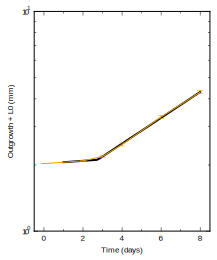

In [490]:
L0 = minuit2.values['L0'] 
r1 = minuit2.values['r1'] 
r2 = minuit2.values['r2'] 
tswitch = minuit2.values['tswitch']

fig, ax = plt.subplots(figsize=(80/25.4,100.0/25.4))
fig.patch.set_alpha(1.0)

# for ID, IDdata in outgrowth.groupby('ID'):
#     pitem = ax.plot(IDdata['time'], IDdata['length'] / 1000.0 + L0, '-', markeredgewidth = 0, color = colors[ID], marker = markers[ID], label = ID)[0]

# plot the average guy last such that you can see him
# ax.plot(outgrowth.query('ID == @averageID')['time'], outgrowth.query('ID == @averageID')['length'] / 1000.0 + L0, '-', markeredgewidth = 0, color = colors[averageID], marker = 's')
ax.plot(time, sp.vectorize(growth_model2)(time, L0, r1, r2, tswitch) + L0, lw = 2)
ax.errorbar(sp.array(mean_outgrowth.index),
                                sp.array(mean_outgrowth['length', 'mean'] + L0),
                                sp.array(mean_outgrowth['length', 'sem']))
    
ax.set_xlabel('Time (days)')
ax.set_ylabel('Outgrowth + L0 (mm)'.decode('utf-8'), labelpad=8)

ax.set_xlim(-0.5, 8.5)
ax.set_xticks([1, 3, 5, 7], minor=True)
ax.set_yscale('log')

plt.show()

In [493]:
minuit.values

{'L0': 0.06702804326025881, 'r': 0.45003665810065296}

In [494]:
minuit2.minos('L0', sigma = 1);

Error,-0.719447722239,1.42399704559
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [496]:
minuit2.minos('L0', sigma = 2);

Error,-1.15355020954,5.53562550449
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [504]:
minuit2.minos('L0', sigma = 3);

Error,-1.43601173992,0.970539729502
Valid,True,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [471]:
minuit2 = iminuit.Minuit(chi2_2, L0 = 3.0, r1 = 0.10, r2 = 0.1, tswitch = 2.5,
                         error_L0 = 0.1, error_r1 = 0.01, error_r2 = 0.01, error_tswitch = 0.1,
                         limit_r1 = (0, None), limit_r2 = (0, None), limit_tswitch = (0.5, None),
                         fix_L0 = True)

In [472]:
minuit2.migrad();

FCN = 1.20252280967 
 TOTAL NCALL = 154 
 NCALLS = 154 
 
 
 EDM = 9.74611676354e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,L0,3.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,,,FIXED
2,r1,9.901341e-03,1.633914e-03,0.000000e+00,0.000000e+00,0.0,,
3,r2,1.018932e-01,2.739342e-03,0.000000e+00,0.000000e+00,0.0,,
4,tswitch,2.787752e+00,8.313742e-02,0.000000e+00,0.000000e+00,0.5,,


### Model comparison

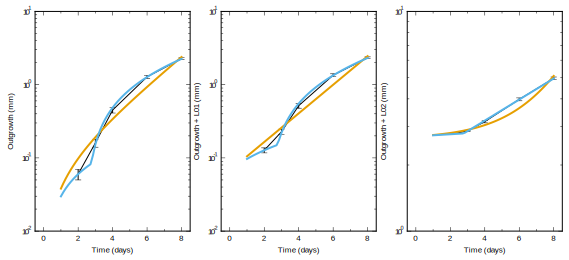

In [433]:
time = sp.linspace(1, 8)

L01 = minuit.values['L0'] 
r = minuit.values['r'] 

L02 = minuit2.values['L0'] 
r1 = minuit2.values['r1'] 
r2 = minuit2.values['r2'] 
tswitch = minuit2.values['tswitch']

fig, axs = plt.subplots(1, 3, figsize=(3*80/25.4,100.0/25.4), sharex = True)
fig.patch.set_alpha(1.0)

# for ID, IDdata in outgrowth.groupby('ID'):
#     pitem = ax.plot(IDdata['time'], IDdata['length'] / 1000.0 + L0, '-', markeredgewidth = 0, color = colors[ID], marker = markers[ID], label = ID)[0]

# plot the average guy last such that you can see him
# ax.plot(outgrowth.query('ID == @averageID')['time'], outgrowth.query('ID == @averageID')['length'] / 1000.0 + L0, '-', markeredgewidth = 0, color = colors[averageID], marker = 's')
for L0plot, ax, title in zip([0, L01, L02], axs, ['', ' + L01', ' + L02']):
    ax.errorbar(sp.array(mean_outgrowth.index)[1:],
                sp.array(mean_outgrowth['length', 'mean'])[1:]+ L0plot,
                sp.array(mean_outgrowth['length', 'sem'])[1:]
               )
    ax.plot(time, sp.vectorize(growth_model)(time, L01, r) + L0plot, lw = 2)
    ax.plot(time, sp.vectorize(growth_model2)(time, L02, r1, r2, tswitch)+ L0plot, lw = 2)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Outgrowth{} (mm)'.format(title), labelpad=8)

    ax.set_xlim(-0.5, 8.5)
    ax.set_xticks([1, 3, 5, 7], minor=True)
    ax.set_yscale('log')

plt.show()

#### AIC

In [418]:
def AIC(minuit):
    SSE = minuit.fval
    # only works if no fixed paramters are used
    k = len(minuit.values)
    
    
    AIC = 2 * k + SSE
    
    return AIC

def AICc(minuit):
    AICv = AIC(minuit)
    k = len(minuit.values)
    n = minuit.fcn.data_len
    AICc = AICv + 2 * k * (k + 1) / (n - k - 1)
    
    return AICc

compute AIC

In [420]:
print AIC(minuit)
print AIC(minuit2)

65.7813563148
8.62372168808


we cannot compute the corrected AIC because of the low number od data points

In [419]:
# print AICc(minuit)
# print AICc(minuit2)